# Lab 2b - Association Analysis for *MatFörAlla*

In this lab, we will look at transaction data from a supermarket.

The grocery store *MatFörAlla* has trouble displaying its products optimally in the store. What the store wants to do is to increase sales to customers. For this, *MatFörAlla* has given you a dataset containing transaction data on what customers bought during every visit to the store.

### Load the data into a matrix

We will use a package called `mlxtend` for this lab. If you wish, can read more about the details of `mlxtend` [here](https://rasbt.github.io/mlxtend/) but it is not necessary for completing this lab exercise.

First, let's load the relevant modules we will use in this lab:

In [1]:
import csv
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib
%matplotlib inline

In [2]:
# Use google drive to load dataset
from google.colab import drive
drive.mount('/content/drive')
gdrive = '/content/drive/MyDrive/data/'

Mounted at /content/drive


The dataset we want to use is available in a local `.csv` file and to load this we need to use the following code:

In [3]:
with open(gdrive+"groceries.csv") as groceries_file:
    dataset = list(csv.reader(groceries_file))
dataset

[['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups'],
 ['tropical fruit', 'yogurt', 'coffee'],
 ['whole milk'],
 ['pip fruit', 'yogurt', 'cream cheese ', 'meat spreads'],
 ['other vegetables',
  'whole milk',
  'condensed milk',
  'long life bakery product'],
 ['whole milk', 'butter', 'yogurt', 'rice', 'abrasive cleaner'],
 ['rolls/buns'],
 ['other vegetables',
  'UHT-milk',
  'rolls/buns',
  'bottled beer',
  'liquor (appetizer)'],
 ['pot plants'],
 ['whole milk', 'cereals'],
 ['tropical fruit',
  'other vegetables',
  'white bread',
  'bottled water',
  'chocolate'],
 ['citrus fruit',
  'tropical fruit',
  'whole milk',
  'butter',
  'curd',
  'yogurt',
  'flour',
  'bottled water',
  'dishes'],
 ['beef'],
 ['frankfurter', 'rolls/buns', 'soda'],
 ['chicken', 'tropical fruit'],
 ['butter', 'sugar', 'fruit/vegetable juice', 'newspapers'],
 ['fruit/vegetable juice'],
 ['packaged fruit/vegetables'],
 ['chocolate'],
 ['specialty bar'],
 ['other vegetables'],
 ['butter milk

If you are unsure what this `.csv` file looks like in its raw format, you check the contents of it in a regular text editor, or by going to the Jupyter dashboard and opening it, just to get a hint of what data we will handle.

Now we will use `mlxtend` to read all the items into a sparse matrix.

Every product item that exists throughout the set of data will have its own column - in other words, if there are 1000 unique items in the dataset then there will be 1000 columns in the matrix. Each row represents a shopping cart with an ID used as the index. The content of each cell in each row represents the number of each product item purchased in a shopping cart.

Below is displayed an explanatory example of how a sparse matrix can look with 3 items and 3
customers. Do you see the difference between the `.csv` file and this matrix?


| &nbsp; | Produkt 1 | Produkt 2 | Produkt 3 |
|:------:|:---------:|:---------:|:---------:|
| Kund 1 |     0     |     0     |     1     |
| Kund 2 |     1     |     1     |     0     |
| Kund 3 |     0     |     1     |     0     |


A sparse matrix is more memory-efficient than keeping each shopping cart record in its full format.

If we had saved it in a full `DataFrame` then we would have had to keep the entire data in the memory, repeating the names of elements that appear more than once. The downside is that we get a matrix with many cells containing just zero.

The `mlxtend` package lets us create the sparse matrix by fitting the input data records using a `TransactionEncoder()` class. We can load it as a Pandas `DataFrame` to inspect more easily:

In [4]:
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
groceries = pd.DataFrame(te_ary, columns=te.columns_)
groceries.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


### Summarize and inspect the transactions

Now you have loaded the dataset that *MatFörAlla* has provided, we need to familiarize ourselves with transactions before generating the association rules.

Use the functions you learned from Lab 1 to describe the groceries dataset by replacing the ellipsis `...` in the next code cell with your own code:

In [5]:
groceries.describe()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
count,9835,9835,9835,9835,9835,9835,9835,9835,9835,9835,...,9835,9835,9835,9835,9835,9835,9835,9835,9835,9835
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,9756,9506,9800,9803,9829,9834,9831,9661,9808,9319,...,9755,9771,9457,9130,9827,9421,9648,7322,8463,9767


In [6]:
groceries.shape

(9835, 169)

*Hint: Run the following cell to get the number of `True` and `False` values in the sparse matrix. This will help you calculate the density.*

In [7]:
groceries.stack().value_counts()

False    1618748
True       43367
dtype: int64

Sometimes it may be desirable to see specific transactions. To do so, use Pandas indexing with `[ ... ]` if you do this on the entire dataset then you will get all the transactions.

In [9]:
groceries[groceries.sum(axis=1) == 1].head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
16,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
groceries[groceries.sum(axis=1) == 1].shape

(2159, 169)

In [11]:
groceries.sum(axis=1).max()

32

In [12]:
groceries[groceries.sum(axis=1) == groceries.sum(axis=1).max()]

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
1216,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,True,True,False


In [13]:
groceries[5:10]

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
5,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


Note that the index shows that you got transactions 5-9, but actually you got transactions 6-10 (`DataFrame`s are indexed starting with row 0).

It is important, however, to understand that the numbers in the output does not show the transaction number, but is an auto-generated ID given by Pandas that simply reflects the row number.

You can also count the numbers of instances of `True`for different items:

In [14]:
groceries.sum().sort_values(ascending=False)[:5]

whole milk          2513
other vegetables    1903
rolls/buns          1809
soda                1715
yogurt              1372
dtype: int64

In [15]:
groceries["soda"].value_counts()

False    8120
True     1715
Name: soda, dtype: int64

In [16]:
groceries[groceries.sum(axis=1) == 1].shape

(2159, 169)

Your task now is to compile what we just got from the output of the code above. The following questions you should try to figure out and make sure to run each cell that contains your answer, and validate them by running the `ok.grade()` cell after Q3.7. Make sure you really try to figure out the answers first before you check if they are correct.

**Q1.** How many product items are in the dataset?

In [17]:
num_product_items_in_dataset = groceries.shape[1]
print(f"Amount of products: {num_product_items_in_dataset}")

Amount of products: 169


**Q2.** How many transactions are there in the dataset?

In [18]:
num_transactions_in_dataset = groceries.shape[0]
print(f"Amount of transactions: {num_transactions_in_dataset}")

Amount of transactions: 9835


**Q3.** What is the density of the dataset? Provide your answer to 5 decimal places.

In [22]:
temp = groceries.stack().value_counts()
dataset_density = temp[1] / temp[0]
dataset_density
print("{:.5f}".format(dataset_density))

0.02679


**Q4.** What are the most common items in the dataset? Provide your answer as a list of string, for example `["potato", "köttbullar"]` etc.

In [23]:
most_common_5_items_df = groceries.apply(pd.value_counts).iloc[1: , :]
most_common_5_items_df = most_common_5_items_df.sort_values(by=[True], axis=1, ascending=False)
most_common_5_items = most_common_5_items_df.columns.tolist()
# First item is the most common item
most_common_5_items

['whole milk',
 'other vegetables',
 'rolls/buns',
 'soda',
 'yogurt',
 'bottled water',
 'root vegetables',
 'tropical fruit',
 'shopping bags',
 'sausage',
 'pastry',
 'citrus fruit',
 'bottled beer',
 'newspapers',
 'canned beer',
 'pip fruit',
 'fruit/vegetable juice',
 'whipped/sour cream',
 'brown bread',
 'domestic eggs',
 'frankfurter',
 'margarine',
 'coffee',
 'pork',
 'butter',
 'curd',
 'beef',
 'napkins',
 'chocolate',
 'frozen vegetables',
 'chicken',
 'white bread',
 'cream cheese ',
 'waffles',
 'salty snack',
 'long life bakery product',
 'dessert',
 'sugar',
 'UHT-milk',
 'hamburger meat',
 'berries',
 'hygiene articles',
 'onions',
 'specialty chocolate',
 'candy',
 'misc. beverages',
 'frozen meals',
 'oil',
 'butter milk',
 'specialty bar',
 'ham',
 'beverages',
 'meat',
 'ice cream',
 'hard cheese',
 'sliced cheese',
 'cat food',
 'grapes',
 'chewing gum',
 'red/blush wine',
 'detergent',
 'white wine',
 'pickled vegetables',
 'semi-finished bread',
 'baking powde

**Q5.** How many of the transactions contain soda?

In [24]:
num_transactions_containing_soda = groceries["soda"].value_counts()
print(f"Amount of transactions containing soda: {num_transactions_containing_soda[1]}")

Amount of transactions containing soda: 1715


**Q6.** How many transactions contain only 1 item?

In [25]:
import numpy as np

#trans_sum = groceries.sum().sort_values(ascending=True)
#num_trans = pd.DataFrame({'item':trans_sum.index, 'count':trans_sum.values})
#items_sold_once = num_trans.loc[num_trans['count'] == 1]
#items_sold_once
#print(f"Items sold once: {items_sold_once}")

num_transactions_containing_1_item = groceries[groceries.sum(axis=1) == 1].shape[0]
print(f"Transactions with 1 item: {num_transactions_containing_1_item}")

Transactions with 1 item: 2159


**Q7.** How many items are in the transaction with the most items?

In [26]:
max_num_product_items_in_a_transcation = groceries.sum(axis=1).max()
print(f"Items in transaction with most items: {max_num_product_items_in_a_transcation}")

Items in transaction with most items: 32


### Frequency of items

If you want to see how many transactions of a particular item relative to the total number of transactions (expressed as a percentage) we can define a function `item_frequency()`.

In [27]:
def item_frequency(dataset):
    return dataset.sum() / len(dataset) * 100

item_frequency(groceries)

Instant food products     0.803254
UHT-milk                  3.345196
abrasive cleaner          0.355872
artif. sweetener          0.325369
baby cosmetics            0.061007
                           ...    
white bread               4.209456
white wine                1.901373
whole milk               25.551601
yogurt                   13.950178
zwieback                  0.691408
Length: 169, dtype: float64

We can also filter by specific column names on the input `DataFrame` by providing the column name within square brackets `[ ... ]`, for example just `meat spreads` we would write: 

In [28]:
item_frequency(groceries['meat spreads'])

0.42704626334519574

We can also filter by specific row numbers on the input `DataFrame`by providing the row range within the square brackets as normal, for example just rows 0 to 3 we would write:

In [29]:
item_frequency(groceries[0:3])

Instant food products     0.000000
UHT-milk                  0.000000
abrasive cleaner          0.000000
artif. sweetener          0.000000
baby cosmetics            0.000000
                           ...    
white bread               0.000000
white wine                0.000000
whole milk               33.333333
yogurt                   33.333333
zwieback                  0.000000
Length: 169, dtype: float64

If you want to look at a specific set of products to compare their frequency, you can provide an array of column names to the `groceries` indexer:

In [30]:
item_frequency(groceries[["whole milk", "butter", "rice"]])

whole milk    25.551601
butter         5.541434
rice           0.762583
dtype: float64

This may be interesting, but it may be more interesting to see such goods occurring over a certain frequency. For this you can further filter out frequencies above a certain degree of support. We can define a new function that we can specify the minimum support:

In [31]:
def item_frequency_plot(dataset, support):
    frequencies = dataset.sum() / len(dataset)
    freq = frequencies[frequencies > support]
    return freq * 100

We can additionally now visualize the results in a bar chart. Fill in the missing parameters to the new function with the input dataset and a minimum support of 0.125:

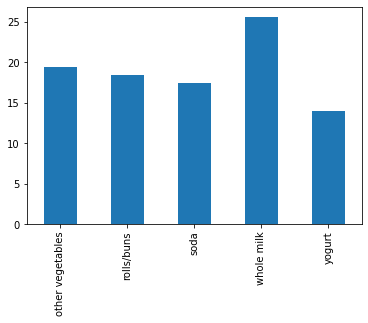

In [32]:
_ = item_frequency_plot(groceries, 0.125).plot.bar()

**Q8.** What does your graph look like? What is the most frequently purchased item according to the transaction data?

The most frequently purchased items are whoel milk, followed by other vegetables, rolls / buns, soda, and yogurt. The plot results align with the results we've seen earlier.

## Extracting Association Rules

*MatFörAlla* is now getting impatient and say that you have only produced things that they already knew and could easily look up in their databases. You promised that you will contribute new knowledge about their customers.

Because you do not want to tempt more on their patience you do not want to end up in to bring out unnecessary rules again. There are three different types of rules - *trivial*, *unexplained* and *actionable*.

*Trivial* are ones that you can easily predict, for example, that you often buy milk and cereal together.

*Unexplainable*. For example, when you buy diapers you might often buy hammer. There is no explanation for why that would be so.

*Actionable* ones are the rules that lead to insight into something and that we can act on. Examples of what we can do are:

1. Have one item at low cost while the other is a little more expensive,
1. Make sure that customers have to go past the goods that are relevant,
1. Alternative ways to market the goods
1. Put the goods closer together.

In order to make it easier for us to talk about rules, we hereby develop one common way to talk about these.

We will now write $Antecedent \rightarrow Consequent$.

Example:

$Toys, wrapping paper \rightarrow Batteries$

It is read out that if you buy toys and wrapping paper you are also likely to buy batteries.

### Measuring Association Rules

There are three different ways to measure association rules. This is to we can evaluate how much weight we should attach to a specific rule.

#### Support

Support is about the number of transactions that contain a certain set of items. The more often items occur together in the input dataset, the greater the support weight.

```
t1: Beef, Carrot, Milk
t2: Steak, Cheese
t3: Cheese, Flingor
t4: Steak, Carrot, Cheese
t5: Steak, Carrot, Butter, Cheese, Milk
t6: Carrot, Butter, Milk
t7: Carrot, Milk, Butter
```

For example,

$$Support(Carrot, Butter, Milk) = \frac{3}{7} = 0.43$$

because the combination of these three items appears 3 times in the input of 7 transactions.

#### Confidence

Confidence is that if there is a rule $Beef, Chicken \rightarrow Apple$ and has a confidence of 33%, we mean that if there is beef and chicken bought together, there is 33% chance that there are also apples in the shopping cart.

Confidence is calculated for example that one has the rule:

$$Butter \rightarrow Milk, Chicken = \frac{Support (Butter \land Milk \land Chicken)}{Support (Butter)}$$

#### Lift

Lift gives us a metric about how good a rule is, only based on the right side of the rule. For example, if items on the right side are already common the rule will not tell us anything valuable.

If the lift is $>1$ then the rule is better than guessing. If the lift is $\leq1$ the rule is pretty much as good as guessing.

For example:

$$Chicken \rightarrow Milk = \frac{Support (Chicken \land Milk)}{Support(Chicken) \times Support (Milk)} = \frac{(4 / 7)}{(5 / 7) \times (4 / 7)} = 1.4$$

This implies that $Chicken \rightarrow Milk$ might be a good rule as $1.4 > 1$. However if we increase the support for milk to $6 \div 7$ to show that it is bought more often in more cases:

$$Chicken \rightarrow Milk = \frac{Support (Chicken \land Milk)}{Support(Chicken) \times Support (Milk)} = \frac{(4 / 7)}{(5 / 7) \times (6 / 7)} = 0.933$$

This now implies $Chicken \rightarrow Milk$ might be a bad rule as $0.933 < 1$. 

### Perform association analysis with Python

Now let's find associations between items in the dataset using default values on support and confidence.

First we create a frequent item sets dataset using the `apriori()` function that calculates the support (item frequency) in a similar method as we did at the beginning of this lab. The function also adds combinations of items into the calculation, and additionally allows us to filter on the minimum support. In this case we set the minimum support to 0.5%:

In [33]:
frequent_itemsets = apriori(groceries, min_support=0.005, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.008033,(Instant food products)
1,0.033452,(UHT-milk)
2,0.017692,(baking powder)
3,0.052466,(beef)
4,0.033249,(berries)
...,...,...
996,0.005186,"(whipped/sour cream, other vegetables, whole m..."
997,0.007829,"(whole milk, other vegetables, root vegetables..."
998,0.007626,"(whole milk, other vegetables, tropical fruit,..."
999,0.005592,"(whipped/sour cream, other vegetables, whole m..."


As you can see, this does not generate rules so we now need to generate them. If you want to decide what values you want to consider, `frequent_itemsets` is a `DataFrame` so you can filter on it before you provide it to the `association_rules()` function.

Note that you can explore the rules generated filtered on different metrics (`support`, `confidence` and `lift`) by specifying the metric and minimum threshold to the function, for example as follows:

In [34]:
grocery_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
grocery_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(UHT-milk),(bottled water),0.033452,0.110524,0.007321,0.218845,1.980074,0.003624,1.138668
1,(UHT-milk),(other vegetables),0.033452,0.193493,0.008134,0.243161,1.256694,0.001662,1.065626
2,(UHT-milk),(rolls/buns),0.033452,0.183935,0.006406,0.191489,1.041071,0.000253,1.009344
3,(UHT-milk),(soda),0.033452,0.174377,0.007626,0.227964,1.307301,0.001793,1.069409
4,(UHT-milk),(yogurt),0.033452,0.139502,0.007422,0.221884,1.590550,0.002756,1.105875
...,...,...,...,...,...,...,...,...,...
1747,"(whole milk, tropical fruit)","(root vegetables, yogurt)",0.042298,0.025826,0.005694,0.134615,5.212371,0.004602,1.125712
1748,"(whole milk, root vegetables)","(tropical fruit, yogurt)",0.048907,0.029283,0.005694,0.116424,3.975803,0.004262,1.098623
1749,"(tropical fruit, yogurt)","(whole milk, root vegetables)",0.029283,0.048907,0.005694,0.194444,3.975803,0.004262,1.180667
1750,"(root vegetables, yogurt)","(whole milk, tropical fruit)",0.025826,0.042298,0.005694,0.220472,5.212371,0.004602,1.228567


We can add columns to calculate the size (number of items contained) of the antecendants:

In [35]:
grocery_rules["num_antecedents"] = grocery_rules["antecedents"].apply(lambda x: len(x))
grocery_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,num_antecedents
0,(UHT-milk),(bottled water),0.033452,0.110524,0.007321,0.218845,1.980074,0.003624,1.138668,1
1,(UHT-milk),(other vegetables),0.033452,0.193493,0.008134,0.243161,1.256694,0.001662,1.065626,1
2,(UHT-milk),(rolls/buns),0.033452,0.183935,0.006406,0.191489,1.041071,0.000253,1.009344,1
3,(UHT-milk),(soda),0.033452,0.174377,0.007626,0.227964,1.307301,0.001793,1.069409,1
4,(UHT-milk),(yogurt),0.033452,0.139502,0.007422,0.221884,1.590550,0.002756,1.105875,1
...,...,...,...,...,...,...,...,...,...,...
1747,"(whole milk, tropical fruit)","(root vegetables, yogurt)",0.042298,0.025826,0.005694,0.134615,5.212371,0.004602,1.125712,2
1748,"(whole milk, root vegetables)","(tropical fruit, yogurt)",0.048907,0.029283,0.005694,0.116424,3.975803,0.004262,1.098623,2
1749,"(tropical fruit, yogurt)","(whole milk, root vegetables)",0.029283,0.048907,0.005694,0.194444,3.975803,0.004262,1.180667,2
1750,"(root vegetables, yogurt)","(whole milk, tropical fruit)",0.025826,0.042298,0.005694,0.220472,5.212371,0.004602,1.228567,2


Use the `describe()` function on your grocery rules dataset to get a summary:

In [36]:
grocery_rules.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction,num_antecedents
count,1752.000000,1752.000000,1752.000000,1752.000000,1752.000000,1752.000000,1752.000000,1752.000000
mean,0.049575,0.130804,0.009602,0.245136,2.007083,0.003996,1.181610,1.529110
std,0.040165,0.067793,0.006838,0.130722,0.687820,0.002832,0.192912,0.551471
min,0.008134,0.021047,0.005084,0.100313,0.445664,-0.011003,0.840156,1.000000
25%,0.024301,0.074835,0.005897,0.139453,1.505919,0.002561,1.063515,1.000000
50%,0.039654,0.108998,0.007219,0.203478,1.875397,0.003487,1.109432,2.000000
75%,0.058566,0.183935,0.010168,0.315980,2.369232,0.004680,1.231814,2.000000
max,0.255516,0.255516,0.074835,0.700000,5.212371,0.026291,2.481613,3.000000


We can filter out the rules by filtering on the `num_antecedents` column we created:

In [37]:
grocery_rules_3_items = grocery_rules[grocery_rules.num_antecedents >= 3]
grocery_rules_3_items

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,num_antecedents
1644,"(whole milk, other vegetables, citrus fruit)",(root vegetables),0.013015,0.108998,0.005796,0.445312,4.085493,0.004377,1.606313,3
1645,"(whole milk, other vegetables, root vegetables)",(citrus fruit),0.023183,0.082766,0.005796,0.250000,3.020577,0.003877,1.222979,3
1646,"(whole milk, citrus fruit, root vegetables)",(other vegetables),0.009151,0.193493,0.005796,0.633333,3.273165,0.004025,2.199566,3
1647,"(other vegetables, citrus fruit, root vegetables)",(whole milk),0.010371,0.255516,0.005796,0.558824,2.187039,0.003146,1.687497,3
1653,"(whole milk, other vegetables, fruit/vegetable...",(yogurt),0.010473,0.139502,0.005084,0.485437,3.479790,0.003623,1.672289,3
1654,"(whole milk, other vegetables, yogurt)",(fruit/vegetable juice),0.022267,0.072293,0.005084,0.228311,3.158135,0.003474,1.202177,3
1655,"(whole milk, fruit/vegetable juice, yogurt)",(other vegetables),0.009456,0.193493,0.005084,0.537634,2.778578,0.003254,1.744307,3
1656,"(other vegetables, fruit/vegetable juice, yogurt)",(whole milk),0.008236,0.255516,0.005084,0.617284,2.415833,0.002979,1.945265,3
1661,"(whole milk, other vegetables, pip fruit)",(root vegetables),0.013523,0.108998,0.005491,0.406015,3.724961,0.004017,1.500041,3
1662,"(whole milk, root vegetables, pip fruit)",(other vegetables),0.008948,0.193493,0.005491,0.613636,3.171368,0.003759,2.087431,3


**Q9.** How many rules have three items?

In [39]:
num_rules_with_three_items = grocery_rules[grocery_rules.num_antecedents == 3]
num_rules_with_three_items
num_rules_with_three_items = len(num_rules_with_three_items)
print(f"Rules with three items: {num_rules_with_three_items}")

Rules with three items: 48


Let's filter further on various rule measures:

In [40]:
grocery_rules[(grocery_rules.num_antecedents >= 3) 
              & (grocery_rules.confidence > 0.6)
              & (grocery_rules.support > 0.0005)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,num_antecedents
1646,"(whole milk, citrus fruit, root vegetables)",(other vegetables),0.009151,0.193493,0.005796,0.633333,3.273165,0.004025,2.199566,3
1656,"(other vegetables, fruit/vegetable juice, yogurt)",(whole milk),0.008236,0.255516,0.005084,0.617284,2.415833,0.002979,1.945265,3
1662,"(whole milk, root vegetables, pip fruit)",(other vegetables),0.008948,0.193493,0.005491,0.613636,3.171368,0.003759,2.087431,3
1664,"(other vegetables, root vegetables, pip fruit)",(whole milk),0.008134,0.255516,0.005491,0.675000,2.641713,0.003412,2.290720,3
1673,"(yogurt, other vegetables, pip fruit)",(whole milk),0.008134,0.255516,0.005084,0.625000,2.446031,0.003005,1.985291,3
1706,"(whipped/sour cream, other vegetables, root ve...",(whole milk),0.008541,0.255516,0.005186,0.607143,2.376144,0.003003,1.895050,3
1717,"(yogurt, other vegetables, root vegetables)",(whole milk),0.012913,0.255516,0.007829,0.606299,2.372842,0.004530,1.890989,3
1727,"(other vegetables, tropical fruit, yogurt)",(whole milk),0.012303,0.255516,0.007626,0.619835,2.425816,0.004482,1.958317,3
1745,"(root vegetables, tropical fruit, yogurt)",(whole milk),0.008134,0.255516,0.005694,0.700000,2.739554,0.003616,2.481613,3


**Q10.** What makes a rule interesting? Is there an interesting rule found in our rules with three antecedents that is worth investigating further?

The rules are interesting since we can see correlations between the store items. For example, customers are likely to buy other vegetables when buying whole milk, citrus fruits, root vegetables or pip fruit. This means that a valid strategy for the store is to place these items nearby which makes it easier for customers to put them in the basket, and might also attract customers to buy those items.
The confidence value indicate that over 60 % of the time the items from the antecedent appeared, the consequent also appeared in the transaction.

Life also suggests that the probability of finding vegetables in transactions with the items mentioned above is higher than other transactions.

Sometimes it may be desirable to want to know the rules that contain a certain product. For example, *MatFörAlla* has had trouble knowing what to put next to citrus fruits. First, we filter out the rules that contain citrus fruit.

In [41]:
citrus_rules = grocery_rules[grocery_rules.antecedents.apply(str).str.contains("citrus fruit")]

Now you can explore the association rules for just citrus fruit:

In [42]:
citrus_rules[(citrus_rules.num_antecedents == 1) 
              & (citrus_rules.confidence > 0.1)
              & (citrus_rules.support > 0.01)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,num_antecedents
61,(citrus fruit),(bottled water),0.082766,0.110524,0.013523,0.163391,1.478332,0.004376,1.063192,1
224,(citrus fruit),(domestic eggs),0.082766,0.063447,0.010371,0.125307,1.974993,0.005120,1.070722,1
228,(citrus fruit),(fruit/vegetable juice),0.082766,0.072293,0.010371,0.125307,1.733327,0.004388,1.060609,1
237,(citrus fruit),(other vegetables),0.082766,0.193493,0.028876,0.348894,1.803140,0.012862,1.238674,1
240,(citrus fruit),(pip fruit),0.082766,0.075648,0.013828,0.167076,2.208594,0.007567,1.109768,1
243,(citrus fruit),(rolls/buns),0.082766,0.183935,0.016777,0.202703,1.102035,0.001553,1.023539,1
244,(citrus fruit),(root vegetables),0.082766,0.108998,0.017692,0.213759,1.961121,0.008671,1.133243,1
247,(citrus fruit),(sausage),0.082766,0.093950,0.011286,0.136364,1.451446,0.003510,1.049110,1
249,(citrus fruit),(soda),0.082766,0.174377,0.012811,0.154791,0.887680,-0.001621,0.976827,1
250,(citrus fruit),(tropical fruit),0.082766,0.104931,0.019929,0.240786,2.294702,0.011244,1.178942,1


**Q11.** What products do you recommend *MatFörAlla* to put next to citrus fruit? Explain your answer.

They should ideally put bottled waters closer to the citrus fruits since many customers tend to also buy water bottles when purchasing citrus fruits. Also, citrus fruits should be close to other fruits and vegetables since these are also popular for citrus-buying customers.

## Conclusion

*MatFörAlla* thank you for your help and are grateful that you arranged so that they now sells much better.

Because you did such a good job, you have also learned that there is some further aspects that *MatFörAlla* wants to know:

**Q12.** *MatFörAlla* can now see which customers have made which transactions. What further possibilities can such data provide?

Other posibilities would be to find the least common items, and tracking common items for specific time periods, for example. This could be benefitial for applying discounts at different time periods, or changing the item placing strategy.

**Q13.** A customer makes a purchase where he buys a candle together with 20 cans of beer and *MatFörAlla* then wonder how this will affect the analysis. You can say with confidence that it will not affect the analysis. Why can you say that?

It won't affect the analysis negatively since the code analyses all transactions and most likely won't input 20 different transactions for every beer. Furthermore, the lift parameter can be used to over the drawback of having a popular item since it takes item popularity into account. We can therefore look at both confidence to discover the the probability of item Y being purchased if item X is purchased. And lift will be used to see the probability of the itemset Y being bought when item X is purchased while also taking the popularity of Y into account.

---
You're done with Lab 2b!

Choose **Save and Checkpoint** from the **File** menu to save your work.

If you are running the labs in Binder (on the cloud), then choose **Download as Notebook** and save it to your computer. 

Now *ZIP* all two Lab 2 notebooks together into one file and [upload it to Studium](https://uppsala.instructure.com/courses/26106/assignments/37622).